# Reconstruction of DICOM data

In [1]:
import sys
sys.path.append('/home/gpuvmadm/PyTomography/src')
import os
from pytomography.projections import ForwardProjectionNet, BackProjectionNet
from pytomography.metadata import ObjectMeta, ImageMeta, PSFMeta
from pytomography.mappings import SPECTAttenuationNet, SPECTPSFNet
from pytomography.algorithms import OSEMOSL
from pytomography.io import dicom_projections_to_data, dicom_CT_to_data, dicom_MEW_to_data, get_SPECT_recon_algorithm_dicom
import numpy as np
import matplotlib.pyplot as plt
import torch
import pydicom
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## The Quick Way

The typical file format for DICOM is as follows:

* **Raw SPECT data**: a single .dcm (DICOM) file (3D sinogram)
* **CT data**: a sequence of .dcm files, each representing a 2D slice

Below we obtain the corresponding files

In [2]:
path = '/home/gpuvmadm/PyTomography/test_files/julia_phantom/Cylinder_0103'
file_NM = os.path.join(path, 'HOLMIUM-166_ZYLINDER_03_01_2023.NM._.1000.1.2023.01.25.17.17.34.968750.4872276.IMA')
files_CT = [os.path.join(path, file) for file in os.listdir(path) if '2023.CT._.2' in file]

From there, we can create the reconstruction algorithm

In [3]:
osem_net = get_SPECT_recon_algorithm_dicom(
            projections_file = file_NM,
            atteunation_files = files_CT,
            use_psf = True,
            scatter_type = 'DEW',
            recon_algorithm_class= OSEMOSL,
            device = device)

Based on primary window with range (74.93, 87.07)keV, using conversion between hounsfield to linear attenuation coefficient based on radionuclide with emission energy 77.5keV


And we can reconstruct using our desired reconstruction algorithm parameters""

In [4]:
reconstructed_object = osem_net(n_iters=4, n_subsets=8)

And we can view a slice of our reconstructed object:

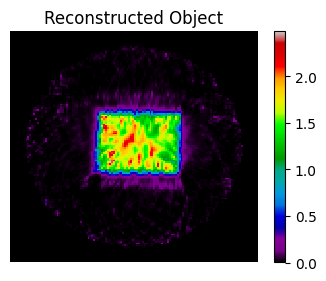

In [5]:
plt.figure(figsize=(4,3))
plt.pcolormesh(reconstructed_object[0].cpu()[:,:,70].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed Object')
plt.show()

## The Methodical Way

We can get the object/image metadata and corresponding projections / scatter projections using the `dicom_MEW_to_data` function (MEW means multiple energy window).

In [6]:
object_meta, image_meta, projections, projections_scatter = dicom_MEW_to_data(file_NM)

We can load the atteunation data using the `dicom_CT_to_data` file, which will automatically align the attenuation object with the SPECT projections.

* The `dicom_CT_to_data` uses the data table `data/HU_to_mu.csv` to convert between the Hounsfield units of the CT to the linear atteunation coefficient data required for doing attenuation correction. The data was taken from https://www.sciencedirect.com/science/article/pii/S0969804308000067. 

In [7]:
CT = dicom_CT_to_data(files_CT, file_NM)

Based on primary window with range (74.93, 87.07)keV, using conversion between hounsfield to linear attenuation coefficient based on radionuclide with emission energy 77.5keV


As usual, it is always good practice to ensure the CT and projections are aligned

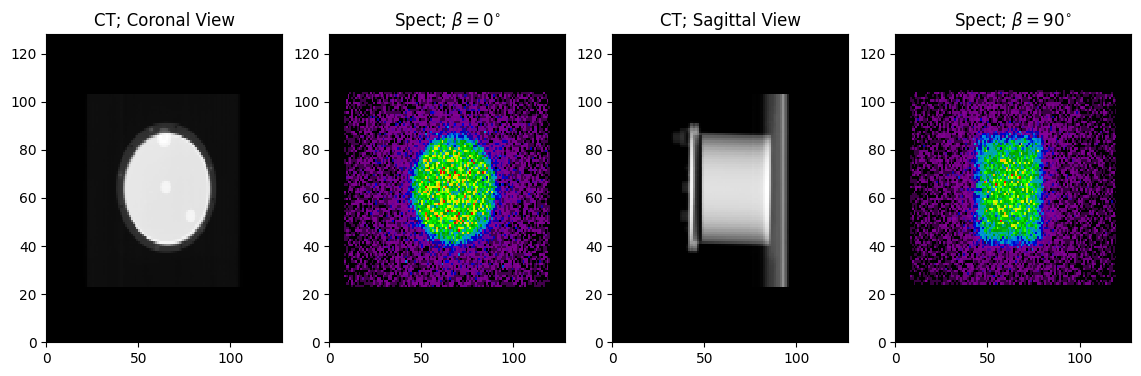

In [8]:
plt.subplots(1, 4, figsize=(14,4))
plt.subplot(141)
plt.pcolormesh(CT.sum(axis=1).T, cmap='Greys_r')
plt.title('CT; Coronal View')
plt.subplot(142)
plt.pcolormesh(projections[0][0].T, cmap='nipy_spectral')
plt.title(r'Spect; $\beta=0^{\circ}$')
plt.subplot(143)
plt.pcolormesh(CT.sum(axis=0).T, cmap='Greys_r')
plt.title('CT; Sagittal View')
plt.subplot(144)
plt.pcolormesh(projections[0][30].T, cmap='nipy_spectral')
plt.title(r'Spect; $\beta=90^{\circ}$')
plt.show()

Now we need to define all the required mappings to model $g = Hf$

CT Correction

In [9]:
ct_net = SPECTAttenuationNet(CT.unsqueeze(dim=0).to(device), device=device)

PSF Correction

* For PSF correction of DICOM SPECT files, we use the angular resolution to obtain an approximation for the collimator slope and intercept.

In [10]:
ds = pydicom.read_file(file_NM)
angular_FWHM = ds[0x0055, 0x107f][0]
psf_meta = PSFMeta(collimator_slope = angular_FWHM/(2*np.sqrt(2*np.log(2))), collimator_intercept = 0.0)
psf_net = SPECTPSFNet(psf_meta, device)

Now we can build our forward and back projection networks:

In [11]:
fp_net = ForwardProjectionNet(
    obj2obj_nets = [ct_net,psf_net],
    im2im_nets = [],
    object_meta = object_meta,
    image_meta = image_meta,
    device = device)
bp_net = BackProjectionNet(
    obj2obj_nets = [ct_net,psf_net],
    im2im_nets = [],
    object_meta = object_meta,
    image_meta = image_meta,
    device = device)

We'll use these FP/BP nets to create the reconstruction algorithm:

In [12]:
osem_net = OSEMOSL(
    image = projections,
    forward_projection_net = fp_net,
    back_projection_net = bp_net,
    scatter = projections_scatter)

Get the reconstructed object

In [13]:
reconstructed_object = osem_net(n_iters=4, n_subsets=8)

Plot the reconstructed object next to the CT.
* The reconstructed object has units of counts, and would need to be adjusted by a proportionality factor if one wants to obtain units of MBq

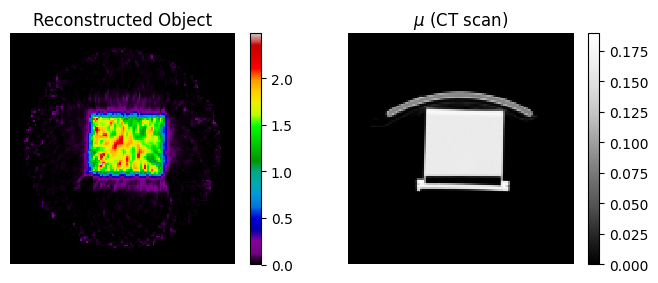

In [14]:
plt.subplots(1,2,figsize=(8,3))
plt.subplot(121)
plt.pcolormesh(reconstructed_object[0].cpu()[:,:,70].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed Object')
plt.subplot(122)
plt.pcolormesh(CT[:,:,70].T, cmap='Greys_r')
plt.colorbar()
plt.axis('off')
plt.title('$\mu$ (CT scan)')
plt.show()